In [4]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

print(f"Running on PyMC3 v{pm.__version__}")
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8924
np.random.seed(286)

Running on PyMC3 v4.0.0b3


In [5]:
az.style.use("arviz-darkgrid")
# Import radon data
srrs2 = pd.read_csv(pm.get_data("srrs2.dat"))
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

In [6]:
srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips
cty = pd.read_csv(pm.get_data("cty.dat"))
cty_mn = cty[cty.st == "MN"].copy()
cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

In [7]:
srrs_mn = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn = srrs_mn.drop_duplicates(subset="idnum")
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

In [8]:
srrs_mn.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm
0,5081,MN,MN,27,55735,5,1,1,3,N,...,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001,0.502054
1,5082,MN,MN,27,55748,5,1,0,4,Y,...,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001,0.502054
2,5083,MN,MN,27,55748,5,1,0,4,Y,...,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001,0.502054
3,5084,MN,MN,27,56469,5,1,0,4,Y,...,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001,0.502054
4,5085,MN,MN,27,55011,3,1,0,4,Y,...,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003,0.428565


In [9]:
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(counties)))

In [10]:
county = srrs_mn["county_code"] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn["log_radon"] = log_radon = np.log(radon + 0.1).values
floor = srrs_mn.floor.values

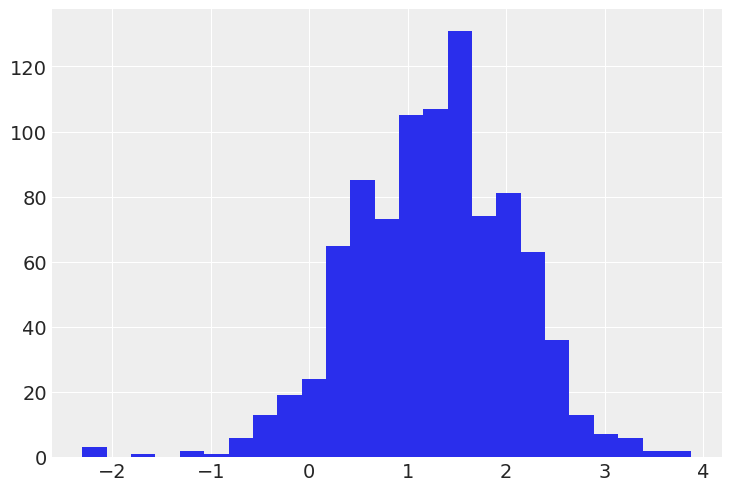

In [11]:
srrs_mn.log_radon.hist(bins=25);

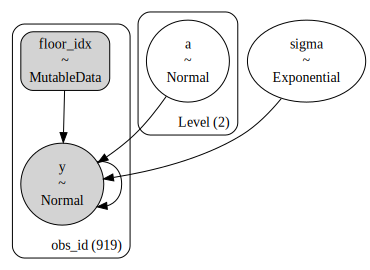

In [12]:
coords = {"Level": ["Basement", "Floor"], "obs_id": np.arange(floor.size)}
with pm.Model(coords=coords) as pooled_model:
    floor_idx = pm.Data("floor_idx", floor, dims="obs_id")
    a = pm.Normal("a", 0.0, sigma=10.0, dims="Level")

    theta = a[floor_idx]
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

pm.model_to_graphviz(pooled_model)

In [14]:
with pooled_model:
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    idata_prior = az.from_pymc(prior=prior_checks)

_, ax = plt.subplots()
idata_prior.prior.plot.scatter(x="Level", y="a", color="k", alpha=0.2, ax=ax)
ax.set_ylabel("Mean log radon level");

AttributeError: module 'arviz' has no attribute 'from_pymc'